<a href="https://colab.research.google.com/github/bailos/D.I.T/blob/main/cotton_disease_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des librairies

In [ ]:
# Importation des librairies

import os
import shutil
import random
import zipfile
import itertools
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras import layers, Sequential, models
from keras.utils import plot_model
from PIL import Image

# Extraction du dataset

In [ ]:
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
# Montage du dossier Google Drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Master_IA_DIT_2022/Projet_DIT')
current_dir = os.getcwd()
print(f"Current directory: {current_dir}")

Mounted at /content/drive
Current directory: /content/drive/.shortcut-targets-by-id/1hjX6fe0Avkk9cNeNiPdTDk4ggUb4JV-H/Projet_DIT


In [ ]:

# Notre dataset archivé se trouve dans le repertoire courant
zip_path = '/content/drive/MyDrive/Master_IA_DIT_2022/Projet_DIT/dataset.zip'
extraction_path = current_dir
# Extraction du fichier archivé dans le repertoire courant
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)


In [ ]:
# Nombre d'images par classe
path = f"{current_dir}/Dataset-2"
classes = os.listdir(path)
for label in classes:
  if label == '.DS_Store':
    continue
  print(f"{label}: contient {len(os.listdir(os.path.join(path, label)))} images")

Healthy: contient 600 images
Powdery Mildew: contient 600 images
Army worm: contient 600 images
Aphids: contient 600 images
Target spot: contient 601 images
Bacterial Blight: contient 600 images


In [ ]:
# Définition de quelques constantes
IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 32
NUM_OF_CLASS = 6

# Importation du dataset

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset-2",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 3601 files belonging to 6 classes.


In [ ]:
class_names = dataset.class_names
print(class_names)

['Aphids', 'Army worm', 'Bacterial Blight', 'Healthy', 'Powdery Mildew', 'Target spot']


## Visualisation des quelques images

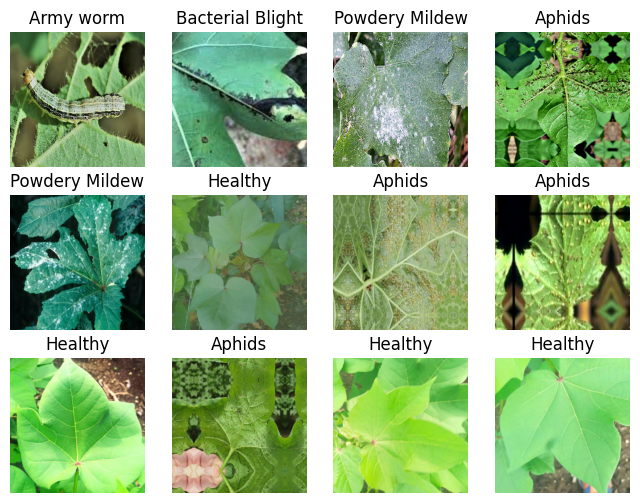

In [ ]:
plt.figure(figsize=(8,6))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

## Split du dataset

In [ ]:
# Définir des dossiers pour le training, validation et test


source_path = os.path.join(current_dir, 'Dataset-2')
destination_path = os.path.join(current_dir, 'data')


class_folders = os.listdir(source_path)


os.makedirs(os.path.join(destination_path, 'train'), exist_ok=True)
os.makedirs(os.path.join(destination_path, 'val'), exist_ok=True)
os.makedirs(os.path.join(destination_path, 'test'), exist_ok=True)


train_ratio = 0.7
val_ratio = 0.15



for class_folder in class_folders:
    class_source_path = os.path.join(source_path, class_folder)


    os.makedirs(os.path.join(destination_path, 'train', class_folder), exist_ok=True)
    os.makedirs(os.path.join(destination_path, 'val', class_folder), exist_ok=True)
    os.makedirs(os.path.join(destination_path, 'test', class_folder), exist_ok=True)


    images = os.listdir(class_source_path)
    num_images = len(images)


    train_size = int(train_ratio * num_images)
    val_size = int(val_ratio * num_images)

    train_images = images[:train_size]
    val_images = images[train_size:train_size + val_size]
    test_images = images[train_size + val_size:]


    for image in train_images:
        shutil.copy(
            os.path.join(class_source_path, image),
            os.path.join(destination_path, 'train', class_folder, image)
        )

    for image in val_images:
        shutil.copy(
            os.path.join(class_source_path, image),
            os.path.join(destination_path, 'val', class_folder, image)
        )

    for image in test_images:
        shutil.copy(
            os.path.join(class_source_path, image),
            os.path.join(destination_path, 'test', class_folder, image)
        )


print("Images copiées avec succès!")

Images copiées avec succès!


In [ ]:
# Nombre d'images par classe dans le training set
classes = os.listdir(os.path.join(current_dir, 'data/train'))
for label in classes:
  print(f"{label}: contient {len(os.listdir(os.path.join(current_dir, 'data/train', label)))} images")

Healthy: contient 420 images
Powdery Mildew: contient 420 images
Army worm: contient 420 images
Aphids: contient 420 images
Target spot: contient 420 images
Bacterial Blight: contient 420 images


### Importation du training set, validation set et test set

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/train",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2520 files belonging to 6 classes.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/val",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "data/test",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 540 files belonging to 6 classes.
Found 541 files belonging to 6 classes.


### Rescaling

In [ ]:
rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    rescale,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(NUM_OF_CLASS, activation='softmax')
])


In [ ]:
model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (32, 256, 256, 3)         0         
                                                                 
 conv2d_62 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_62 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_63 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_63 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_64 (Conv2D)          (32, 60, 60, 64)        

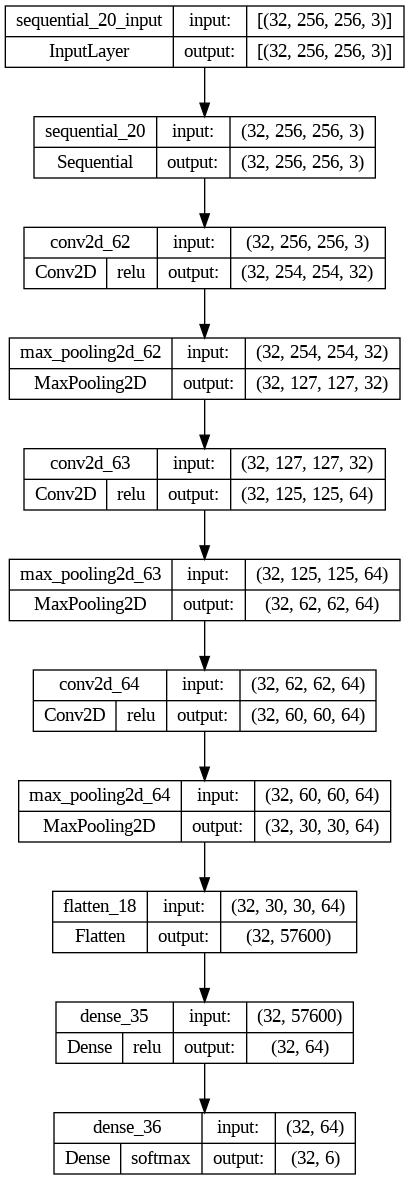

In [ ]:
plot_model(model, to_file='first_model.png', show_layer_activations=True, show_shapes=True)

In [ ]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
EPOCHS = 20
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/20
79/79 [==============================] - 22s 241ms/step - loss: 1.4355 - accuracy: 0.4329 - val_loss: 1.1800 - val_accuracy: 0.5759
Epoch 2/20
79/79 [==============================] - 18s 214ms/step - loss: 0.8155 - accuracy: 0.7099 - val_loss: 0.7846 - val_accuracy: 0.7407
Epoch 3/20
79/79 [==============================] - 21s 239ms/step - loss: 0.5006 - accuracy: 0.8321 - val_loss: 0.6484 - val_accuracy: 0.7833
Epoch 4/20
79/79 [==============================] - 22s 254ms/step - loss: 0.2796 - accuracy: 0.9071 - val_loss: 0.7473 - val_accuracy: 0.7926
Epoch 5/20
79/79 [==============================] - 20s 239ms/step - loss: 0.1738 - accuracy: 0.9377 - val_loss: 0.9127 - val_accuracy: 0.7778
Epoch 6/20
79/79 [==============================] - 18s 213ms/step - loss: 0.1179 - accuracy: 0.9647 - val_loss: 0.8311 - val_accuracy: 0.8037
Epoch 7/20
79/79 [==============================] - 18s 217ms/step - loss: 0.0641 - accuracy: 0.9790 - val_loss: 1.0522 - val_accuracy: 0.8019

In [ ]:
scores = model.evaluate(test_ds)

17/17 [==============================] - 3s 109ms/step - loss: 1.4271 - accuracy: 0.8336


In [ ]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 79}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

## Visualisation des erreurs et de l'accuracy

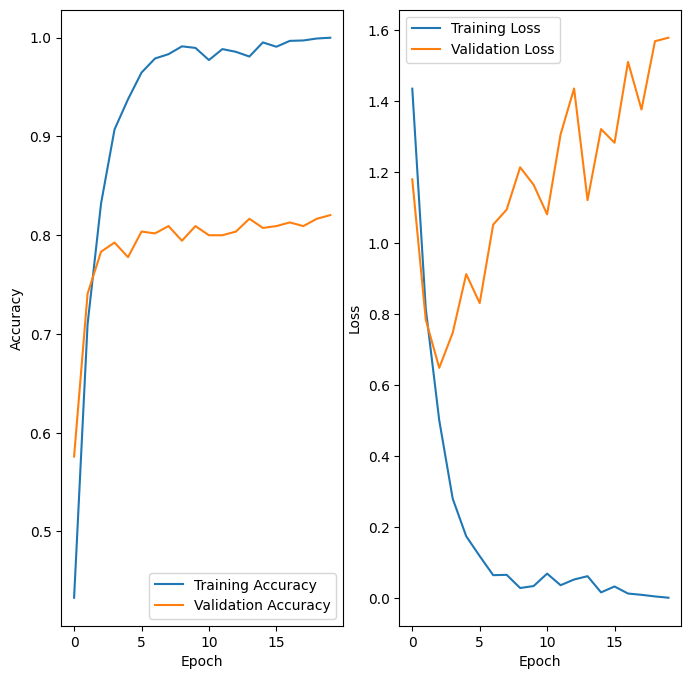

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#plt.tight_layout()
plt.show()


## Optimisation du modèle

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    rescale,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_OF_CLASS, activation='softmax')
])

In [ ]:
model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_20 (Sequential)  (None, 256, 256, 3)       0         
                                                                 
 conv2d_80 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_80 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_81 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_81 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_82 (Conv2D)          (32, 60, 60, 64)        

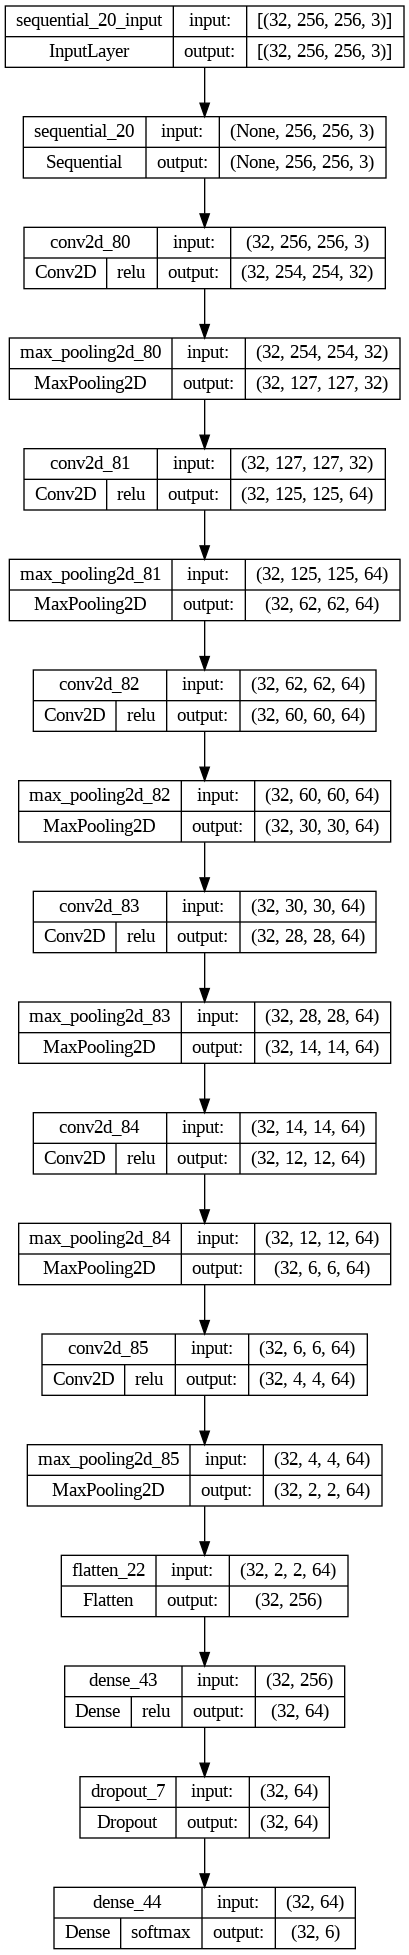

In [ ]:
plot_model(model, to_file='second_model.png', show_layer_activations=True, show_shapes=True)

In [ ]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [ ]:
EPOCHS = 100
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/100
79/79 [==============================] - 20s 233ms/step - loss: 1.6025 - accuracy: 0.3194 - val_loss: 1.4806 - val_accuracy: 0.3667
Epoch 2/100
79/79 [==============================] - 18s 209ms/step - loss: 1.4769 - accuracy: 0.3754 - val_loss: 1.3866 - val_accuracy: 0.4370
Epoch 3/100
79/79 [==============================] - 18s 209ms/step - loss: 1.3303 - accuracy: 0.4655 - val_loss: 1.1639 - val_accuracy: 0.5352
Epoch 4/100
79/79 [==============================] - 19s 216ms/step - loss: 1.1366 - accuracy: 0.5762 - val_loss: 1.0157 - val_accuracy: 0.6185
Epoch 5/100
79/79 [==============================] - 17s 208ms/step - loss: 0.9582 - accuracy: 0.6468 - val_loss: 0.8386 - val_accuracy: 0.6852
Epoch 6/100
79/79 [==============================] - 18s 209ms/step - loss: 0.8762 - accuracy: 0.6758 - val_loss: 0.7967 - val_accuracy: 0.7074
Epoch 7/100
79/79 [==============================] - 18s 219ms/step - loss: 0.7322 - accuracy: 0.7460 - val_loss: 0.7023 - val_accuracy:

NotFoundError: ignored

In [ ]:
scores = model.evaluate(test_ds)

17/17 [==============================] - 4s 132ms/step - loss: 0.9359 - accuracy: 0.8189


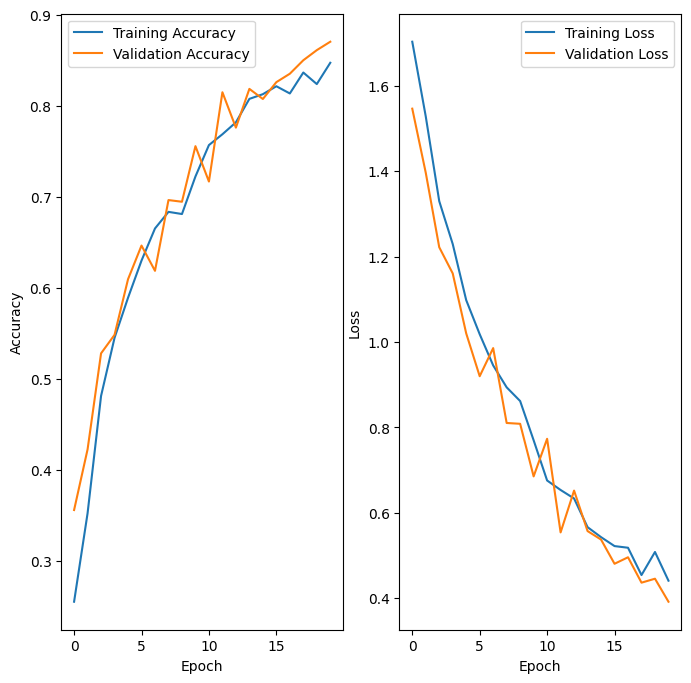

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(1, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(NUM_OF_CLASS, activation='softmax')
])